# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [325]:
# import packages

# data extraction
from sqlalchemy import create_engine

# standard data processing
import pandas as pd
import numpy as np
import sys

# tokenization
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# visualization libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extracting sklearn liabraries

from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/oleksandryatsenko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oleksandryatsenko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/oleksandryatsenko/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [326]:
def load_data():
    # load data from database
    engine = create_engine('sqlite:///TweetsDatabase.db')
    df = pd.read_sql_table('TweetsDatabase', engine)
    
    # defining features - X and labels y
    X = df['message']
    y = df.drop(['id','original','message','genre'], axis = 1)
    
    # Replacing rougue 2 values
    y.related.replace('2','1',inplace=True)
    y = y.astype(int)
    return X,y

In [327]:
X,y = load_data()

In [328]:
print(np.unique(y))

[0 1]


In [329]:
# verifying total cases of each instance in the features
for col in list(y.columns):
    cases = y[col].sum()
    print(col, cases)

related 20094
request 4474
offer 118
aid_related 10860
medical_help 2084
medical_products 1313
search_and_rescue 724
security 471
military 860
child_alone 0
water 1672
food 2923
shelter 2314
clothing 405
money 604
missing_people 298
refugees 875
death 1194
other_aid 3446
infrastructure_related 1705
transport 1201
buildings 1333
electricity 532
tools 159
hospitals 283
shops 120
aid_centers 309
other_infrastructure 1151
weather_related 7297
floods 2155
storm 2443
fire 282
earthquake 2455
cold 530
other_weather 1376
direct_report 5075


In [330]:
# removing columns without records

y = y.drop(['child_alone'], axis=1)

### 2. Write a tokenization function to process your text data

In [331]:
def tokenize(text):
    # text cleaning
    text = text.lower() # Convert to lowercase
    text = re.sub('[^A-Za-z0-9]+',' ', text) # removing punctuation
    words = nltk.word_tokenize(text) # tokenizing words
    stop_words = set(stopwords.words('english')) # adding set of stopwords
    filtered_words = [w for w in words if not w.lower() in stop_words] # filtering words
    
    # initiate lemmatizer
    lemmatizer = WordNetLemmatizer()

    # iterate through each token
    clean_tokens = []
    for tok in filtered_words:
        # lemmatization
        clean_tok = lemmatizer.lemmatize(tok)
        clean_tokens.append(clean_tok)
    return clean_tokens

### Pipeline components

In [332]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

In [333]:
def display_results(y_test, y_pred):
    labels = list(y_test.columns.values)
    vis_arr = multilabel_confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(4, 4, figsize=(18, 9))
    
    return labels, ax, fig, vis_arr
    
    # accuracy = (y_pred == y_test).mean()
    # print("Labels:", labels)
    # print("Confusion Matrix:\n", confusion_mat)
    # print("Accuracy:", accuracy)

In [334]:
def model_pipeline():
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        #('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))),
        ('clf', RandomForestClassifier()),
    ])
    
    # WARNING: check the full set of all parameters we can use in gridsearch - pipeline.get_params()
    parameters = {
        'tfidf__use_idf': (True, False)
    }

    # cv = GridSearchCV(pipeline, param_grid=parameters)
    cv = GridSearchCV(pipeline, param_grid=parameters, cv = 3)
    return cv
        # 'clf__n_estimators': [50, 100, 200],
        # 'clf__min_samples_split': [2, 3, 4],
        # 'tfidf__use_idf': (True, False),
        # 'vect__ngram_range': ((1, 1), (1, 2)),
        # 'vect__max_df': (0.5, 0.75, 1.0),
        # 'vect__max_features': (None, 5000, 10000),

In [335]:
def main():
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, shuffle=True)
    
    # stratify=y,
    # iterative train test-split for stratified sampling
    # X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=0.2)

    model = model_pipeline()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    labels, ax, fig, vis_arr = display_results(y_test, y_pred)
    
    # WARNING: verify that ["Y", "N"] is the right position for TP/TN
    for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"]) 

    fig.tight_layout()
    plt.show() # this actually returns charts
    print(classification_report(y_test, y_pred))

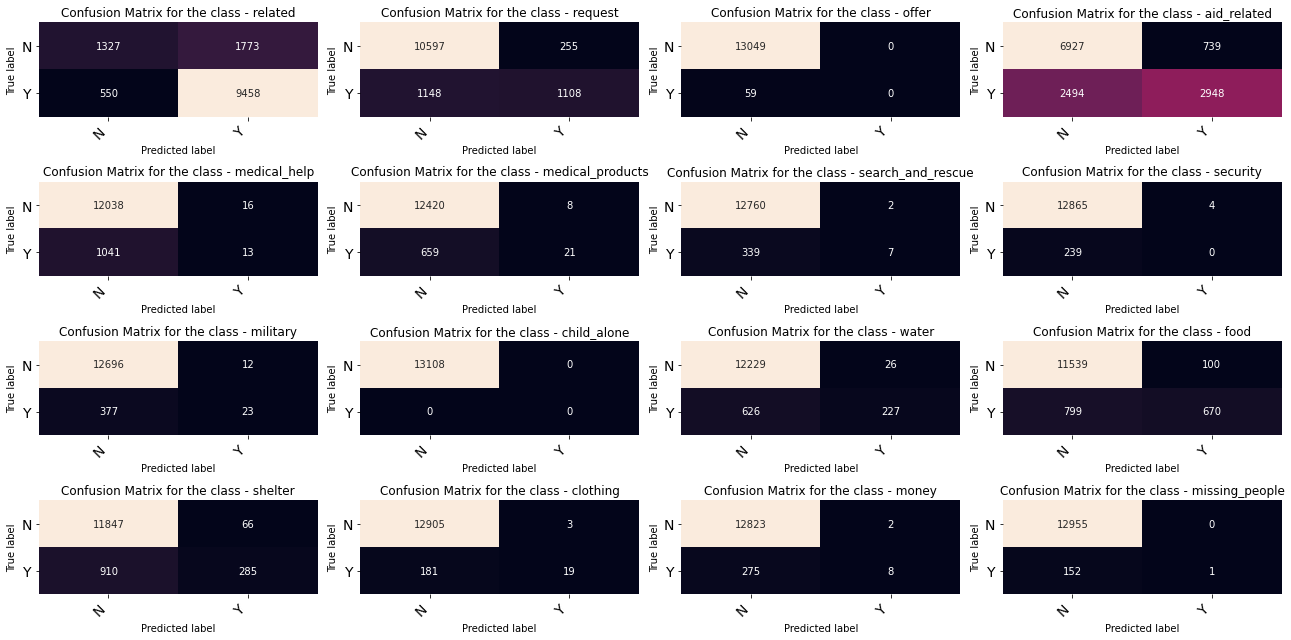

              precision    recall  f1-score   support

           0       0.84      0.95      0.89     10008
           1       0.81      0.49      0.61      2256
           2       0.00      0.00      0.00        59
           3       0.80      0.54      0.65      5442
           4       0.45      0.01      0.02      1054
           5       0.72      0.03      0.06       680
           6       0.78      0.02      0.04       346
           7       0.00      0.00      0.00       239
           8       0.66      0.06      0.11       400
           9       0.00      0.00      0.00         0
          10       0.90      0.27      0.41       853
          11       0.87      0.46      0.60      1469
          12       0.81      0.24      0.37      1195
          13       0.86      0.10      0.17       200
          14       0.80      0.03      0.05       283
          15       1.00      0.01      0.01       153
          16       0.60      0.01      0.03       437
          17       0.90    

/Users/oleksandryatsenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/oleksandryatsenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/oleksandryatsenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

In [336]:
main()

### Previewing results

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(y_true=y_test, y_pred=y_pred, average='weighted')

In [ ]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
precision_score(y_true=y_test, y_pred=y_pred, average='weighted')

In [ ]:
recall_score(y_true=y_test, y_pred=y_pred, average='weighted')

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [ ]:
pipeline = 

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
parameters = 

cv = 

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.